In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from sbi.analysis import pairplot
from sbi.inference import NPE
from torch.distributions import Normal, Uniform

from npe_pfn import TabPFN_Based_NPE_PFN, run_tsnpe_pfn

# seed
torch.manual_seed(42)

ModuleNotFoundError: No module named 'torch.nn.attention'

## Define simulator and prior, and run some simulations.

In [2]:
# define simulator and prior
def two_moons_simulator(theta):
    size_theta = theta.shape

    uniform = Uniform(
        torch.zeros(size_theta[0]) + (-np.pi / 2),
        torch.zeros(size_theta[0]) + (np.pi / 2),
    )
    # mean_radius=0.1, std_radius=0.01
    normal = Normal(
        torch.zeros(size_theta[0]) + 0.1,
        torch.zeros(size_theta[0]) + 0.01,
    )

    a = uniform.rsample()
    r = normal.rsample()

    p = torch.empty(size_theta)

    p[:, 0] = torch.mul(r, torch.cos(a)) + 0.25
    p[:, 1] = torch.mul(r, torch.sin(a))

    q = torch.empty(size_theta)
    q[:, 0] = -torch.abs(theta[:, 0] + theta[:, 1]) / np.sqrt(2)
    q[:, 1] = (-theta[:, 0] + theta[:, 1]) / np.sqrt(2)

    return p + q


prior = Uniform(-torch.ones(2), torch.ones(2))

# number of simulations and posterior samples
num_simulations = 1000
num_posterior_samples = 1000
thetas = prior.sample((num_simulations,))
# simulate data
xs = two_moons_simulator(thetas)


# observation
theta_o = 0.5 * torch.ones(1, 2)
x_o = two_moons_simulator(theta_o)

## Comparison of standard flow-based NPE (from the `sbi` library) and NPE-PFN

The default context size of NPE-PFN is set to 10,000 simulations. If you append more simulations, the context will optimized using filtering. By default, the simulations are filtered using the Euclidean distance in standardized feature space.

In [ ]:
print("Method: NPE")
inference_npe = NPE(prior=prior)
inference_npe.append_simulations(thetas, xs)
print("Training ...")
inference_npe.train()
posterior_npe = inference_npe.build_posterior()
print(" Sampling ...")
samples_npe = posterior_npe.sample((num_posterior_samples,), x=x_o)

print("Method: NPE-PFN")
npe_pfn_posterior = TabPFN_Based_NPE_PFN(prior=prior)
npe_pfn_posterior.append_simulations(thetas, xs)
# NO TRAINING!
print("Sampling ...")
samples_npepfn = npe_pfn_posterior.sample((num_posterior_samples,), x=x_o)

Method: NPE
Training ...
 Neural network successfully converged after 214 epochs. Sampling ...


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Method: NPE-PF
Sampling ...


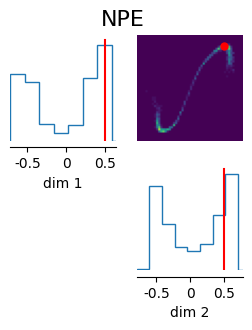

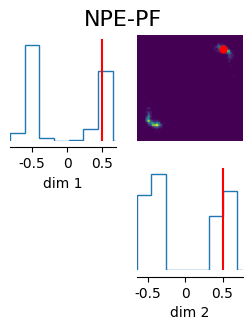

In [ ]:
for samples, title in [
    (samples_npe, "NPE"),
    (samples_npepfn, "NPE-PFN"),
]:
    pairplot(
        samples,
        points=theta_o.reshape(1, -1),
        figsize=(3, 3),
        fig_kwargs={
            "marker": "x",
            "s": 100,
            "points_colors": "red",
            "title": title,
        },
    )
    plt.show()
    plt.close()

## Run sequential inference with TSNPE-PFN
The `run_tsnpe_pfn` function returns a `TabPFN_Based_NPE_PFN` object. Keep in mind, that the context is optimized over several rounds for the given observation. 
Using the resulting inference object for other observations might result in decreased performance.

In [ ]:
tsnpe_pfn_posterior = run_tsnpe_pfn(
    simulator=two_moons_simulator,
    prior=prior,
    observation=x_o,
    num_simulations=1_000,
    num_rounds=5,
    proposal_batch_size=1000,
    simulation_batch_size=1000,
)

Reduced simulation_batch_size to num_simulation_per_round


  0%|          | 0/1 [00:00<?, ?it/s]

Drawing 200 restricted posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Drawing 200 restricted posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Drawing 200 restricted posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Drawing 200 restricted posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

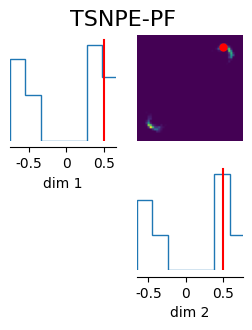

In [ ]:
samples_tsnpepfn = tsnpe_pfn_posterior.sample((num_posterior_samples,), x=x_o)
pairplot(
    samples_tsnpepfn,
    points=theta_o.reshape(1, -1),
    figsize=(3, 3),
    fig_kwargs={
        "marker": "x",
        "s": 100,
        "points_colors": "red",
        "title": "TSNPE-PFN",
    },
)
plt.show()
plt.close()